# Dependence:
- tensorflow-gpu 1.11
- keras 2.2.4
- keras-vis 0.4.1

# Image augmentation and input data preparation

In [27]:
import os
import numpy as np
import glob
import cv2

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator( rotation_range=90,
                              brightness_range=[0.1,0.8],
                             width_shift_range=0.2,
                             height_shift_range=0.2,
#                              shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='constant',cval=255,                     
#                              rescale=1./255,
#                              channel_shift_range=0.2,
                             vertical_flip=True)

def imagepreprocessing(I):
    image = load_img(I).resize([224,224])
    image = img_to_array(image)  
    I = image
#     I = image/255
    return I

testdir = './my_crop/'
len([lists for lists in os.listdir(testdir) if os.path.isfile(os.path.join(testdir, lists))])

for parent,dirnames,filenames in os.walk(testdir): 
    for dirname in dirnames:     
        test_dir = parent+dirname
        print("test dir is:" +test_dir)
        imagenum = len([lists for lists in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, lists))])

        i = 0
        testimage = np.zeros(shape=(imagenum,224,224,3))

        for img_name in glob.glob(test_dir+'/*.jpg'):
            testimage[i,:,:,:] =  imagepreprocessing(img_name)
            i +=1  
        print(testimage.shape)

        i = 0
        save_path = './my_crop_aug/'+dirname
        
        if os.path.isdir(save_path): 
            pass
        else:
            os.makedirs(save_path) 

        for batch in datagen.flow(testimage, 
                                  batch_size=32,
                                  save_to_dir=save_path,  
                                  save_format='jpg'):
            i +=1
            if i ==(np.ceil(imagenum/32)*10):
                break 

test dir is:./my_crop/Tomato___Bacterial_spot
(34, 224, 224, 3)
test dir is:./my_crop/Tomato___Tomato_Yellow_Leaf_Curl_Virus
(112, 224, 224, 3)
test dir is:./my_crop/Tomato___Leaf_Mold
(57, 224, 224, 3)
test dir is:./my_crop/Tomato___Spider_mites Two-spotted_spider_mite
(18, 224, 224, 3)
test dir is:./my_crop/Tomato___Tomato_mosaic_virus
(111, 224, 224, 3)
test dir is:./my_crop/Tomato___healthy
(82, 224, 224, 3)
test dir is:./my_crop/Tomato___Late_blight
(63, 224, 224, 3)
test dir is:./my_crop/Tomato___Septoria_leaf_spot
(51, 224, 224, 3)
test dir is:./my_crop/Tomato___Early_blight
(61, 224, 224, 3)
test dir is:./my_crop/Tomato___Target_Spot
(11, 224, 224, 3)


In [1]:
import os
import random
import shutil
import PIL.Image as Image

def mkdir(path):       
    import os
    path = path.strip()    
    path = path.rstrip("\\")      
    isExists = os.path.exists(path)

    if not isExists:        
        os.makedirs(path) 
        print(path)
        print('Make the directory')
        return True
    else:      
        print(path)
        print('The directory exist')
        return False
 

def eachFile(filepath):
    pathDir =  os.listdir(filepath)
    child_file_name=[]
    full_child_file_list = []
    for allDir in pathDir:
        child = os.path.join('%s%s' % (filepath, allDir))      
        full_child_file_list.append(child)
        child_file_name.append(allDir)
    return  full_child_file_list,child_file_name
 
def eachFile1(filepath):
    dir_list = []
    name_list = []
    pathDir =  os.listdir(filepath)
    for allDir in pathDir:
        name_list.append(allDir)
        child = os.path.join('%s%s' % (filepath+'/', allDir))
        dir_list.append(child)
    return  dir_list,name_list
 
def datapreparation(datasetname):
    filePath,danzi_list = eachFile("./"+datasetname+"/")
    for i in danzi_list:
        path  = './newtrain/' +i
        mkdir(path)
        path = './newtest/' + i
        mkdir(path)
        
    train_pic_dir=[]
    test_pic_dir=[]
    for i in filePath:
        pic_dir,pic_name=eachFile1(i)
        random.shuffle(pic_dir)
        train_list=pic_dir[0:int(0.9*len(pic_dir))]
        test_list=pic_dir[int(0.9*len(pic_dir)):]
        for j in train_list:   
            fromImage = Image.open(j)
            j=j.replace(datasetname,'newtrain')
            fromImage.save(j)
        for k in test_list:
            fromImage = Image.open(k)
            k=k.replace(datasetname,'newtest')
            fromImage.save(k)        


if __name__ == '__main__':
#     datapreparation('color')
    datapreparation('my_crop_aug')

./newtrain/Tomato___Bacterial_spot
The directory exist
./newtest/Tomato___Bacterial_spot
The directory exist
./newtrain/Tomato___Tomato_Yellow_Leaf_Curl_Virus
The directory exist
./newtest/Tomato___Tomato_Yellow_Leaf_Curl_Virus
The directory exist
./newtrain/Tomato___Leaf_Mold
The directory exist
./newtest/Tomato___Leaf_Mold
The directory exist
./newtrain/Tomato___Spider_mites Two-spotted_spider_mite
The directory exist
./newtest/Tomato___Spider_mites Two-spotted_spider_mite
The directory exist
./newtrain/Tomato___Tomato_mosaic_virus
The directory exist
./newtest/Tomato___Tomato_mosaic_virus
The directory exist
./newtrain/Tomato___healthy
The directory exist
./newtest/Tomato___healthy
The directory exist
./newtrain/Tomato___Late_blight
The directory exist
./newtest/Tomato___Late_blight
The directory exist
./newtrain/Tomato___Septoria_leaf_spot
The directory exist
./newtest/Tomato___Septoria_leaf_spot
The directory exist
./newtrain/Tomato___Early_blight
The directory exist
./newtest/Tom

# Training VGG16

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import keras.layers as layers
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras import applications,metrics,optimizers
from keras import backend as K
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from keras.utils import  plot_model

model = applications.VGG16(include_top=False, weights='imagenet')
imagesize =224

input = layers.Input(shape=(imagesize,imagesize,3),name='image_input')

x = layers.GlobalMaxPooling2D()(model(input))
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('softmax',name='pred')(x) 

model = Model(inputs = input, outputs= x)
model.summary()

train_data_dir = './newtrain/'

BATCH_SIZE =32
datagen = ImageDataGenerator(  rescale=1. / 255,
                             brightness_range=[0.1,0.8],
#                              channel_shift_range=0.5,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rotation_range=90,
                             width_shift_range=0.3,
                             height_shift_range=0.3,                               
                             zoom_range=0.5
#                              shear_range=0.5
                            )
train_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='validation')
# print(train_generator.class_indices)

epochs = 50
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epochs)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])


callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint(filepath="./model/VGG16_0401.h5", verbose=1, save_best_only=True),
    TensorBoard(log_dir="./log/VGG16_0401"),
]

history1 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator),
                    validation_data=validation_generator,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks)
fw = open("history04011.txt",'w+')
fw.write(str(history1.history))    
fw.close()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Training Inception_v3

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import keras.layers as layers
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras import applications,metrics,optimizers
from keras import backend as K
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from keras.utils import  plot_model

model = applications.InceptionV3(include_top=False, weights='imagenet')

imagesize =224

input = layers.Input(shape=(imagesize,imagesize,3),name='image_input')

x = layers.GlobalMaxPooling2D()(model(input))
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('softmax',name='pred')(x) 

model = Model(inputs = input, outputs= x)
model.summary()

train_data_dir = './newtrain/'

BATCH_SIZE =24
datagen = ImageDataGenerator(  rescale=1. / 255,
                             brightness_range=[0.1,0.8],
#                              channel_shift_range=0.5,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rotation_range=90,
                             width_shift_range=0.3,
                             height_shift_range=0.3,                               
                             zoom_range=0.5
#                              shear_range=0.5
                            )
train_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='validation')
# print(train_generator.class_indices)

epochs = 50
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epochs)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])


callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint(filepath="./model/Inception_0401.h5", verbose=1, save_best_only=True),
    TensorBoard(log_dir="./log/Inception_0401"),
]

history2 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator),
                    validation_data=validation_generator,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks)

fw = open("history04012.txt",'w+')
fw.write(str(history2.history))    
fw.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_99 (Batc (None, 256)               1024      
_________________________________________________________________
activation_98 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
__________


Epoch 00027: val_loss improved from 0.07060 to 0.07042, saving model to ./model/Inception_0401.h5
Epoch 28/50
815/815 [==============================] - 188s 231ms/step - loss: 0.1567 - acc: 0.9640 - val_loss: 0.1032 - val_acc: 0.9677

Epoch 00028: val_loss did not improve from 0.07042
Epoch 29/50
815/815 [==============================] - 188s 231ms/step - loss: 0.1588 - acc: 0.9639 - val_loss: 0.0788 - val_acc: 0.9742

Epoch 00029: val_loss did not improve from 0.07042
Epoch 30/50
815/815 [==============================] - 187s 230ms/step - loss: 0.1463 - acc: 0.9675 - val_loss: 0.1000 - val_acc: 0.9705

Epoch 00030: val_loss did not improve from 0.07042
Epoch 31/50
815/815 [==============================] - 201s 246ms/step - loss: 0.1380 - acc: 0.9689 - val_loss: 0.0622 - val_acc: 0.9820

Epoch 00031: val_loss improved from 0.07042 to 0.06220, saving model to ./model/Inception_0401.h5
Epoch 32/50
815/815 [==============================] - 200s 246ms/step - loss: 0.1335 - acc: 0.970

# Plot the training process

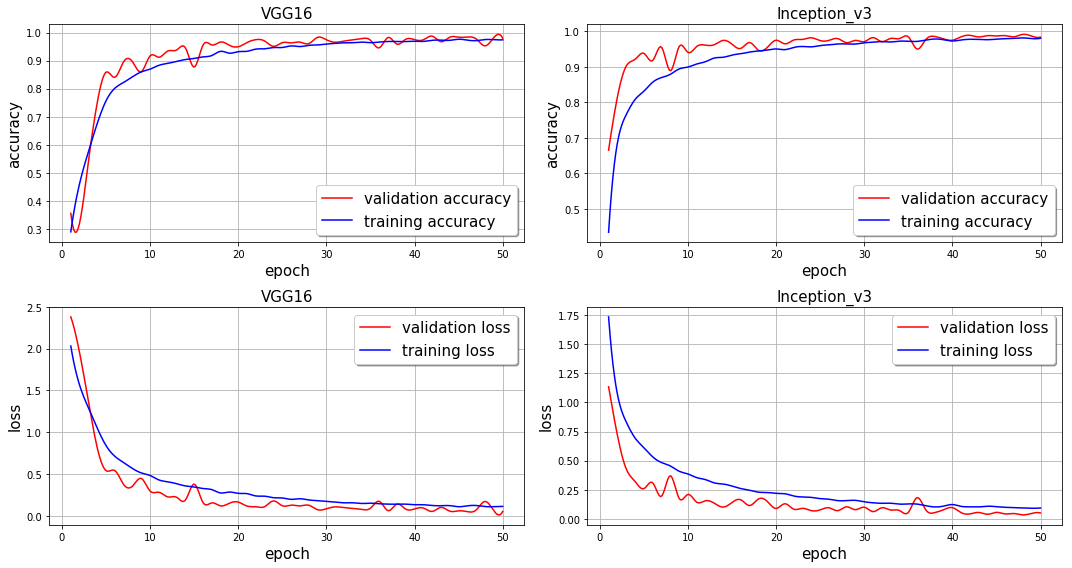

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


def smoothline(val,T):  
    t, c, k = interpolate.splrep(T, val, s=0, k=3)
    smooth = interpolate.BSpline(t, c, k, extrapolate=True)
    return smooth



fr = open("history04011.txt",'r+')
history1 = eval(fr.read())   #读取的str转换为字典
fr.close()
fr = open("history04012.txt",'r+')
history2 = eval(fr.read())   #读取的str转换为字典
fr.close()

T = np.array(range(1,51))
val_acc_vgg = history1['val_acc']
acc_vgg = history1['acc']
val_loss_vgg = history1['val_loss']
loss_vgg = history1['loss']

val_acc_vgg_smooth = smoothline(val_acc_vgg,T)
acc_vgg_smooth = smoothline(acc_vgg,T)
val_loss_vgg_smooth = smoothline(val_loss_vgg,T)
loss_vgg_smooth = smoothline(loss_vgg,T)


val_acc_ince = history2['val_acc']
acc_ince = history2['acc']
val_loss_ince = history2['val_loss']
loss_ince = history2['loss']

val_acc_ince_smooth = smoothline(val_acc_ince,T)
acc_ince_smooth = smoothline(acc_ince,T)
val_loss_ince_smooth = smoothline(val_loss_ince,T)
loss_ince_smooth = smoothline(loss_ince,T)


fig= plt.figure(figsize=(15,8))

# Returns the Axes instance
xnew = np.linspace(T.min(),T.max(),300) #300 represents number of points to make between T.min and T.max 

ax1 = fig.add_subplot(221) 
ax1.plot(xnew,val_acc_vgg_smooth(xnew) ,'r',label="validation accuracy")
ax1.plot(xnew,acc_vgg_smooth(xnew),'b',label="training accuracy")
ax1.legend(loc='best',shadow=True,prop={'size':15})
ax1.set_title('VGG16',fontsize='15')
ax1.set_xlabel('epoch',fontsize='15')
ax1.set_ylabel('accuracy',fontsize='15')
ax1.grid(True)

ax2 = fig.add_subplot(222) 
ax2.plot(xnew,val_acc_ince_smooth(xnew),'r',label="validation accuracy")
ax2.plot(xnew,acc_ince_smooth(xnew),'b',label="training accuracy")
ax2.legend(loc='best',shadow=True,prop={'size':15})
ax2.set_title('Inception_v3',fontsize='15')
ax2.set_xlabel('epoch',fontsize='15')
ax2.set_ylabel('accuracy',fontsize='15')
ax2.grid(True)

ax3 = fig.add_subplot(223) 
ax3.plot(xnew,val_loss_vgg_smooth(xnew) ,'r',label="validation loss")
ax3.plot(xnew,loss_vgg_smooth(xnew) ,'b',label="training loss")
ax3.legend(loc='best',shadow=True,prop={'size':15})
ax3.set_title('VGG16',fontsize='15')
ax3.set_xlabel('epoch',fontsize='15')
ax3.set_ylabel('loss',fontsize='15')
ax3.grid(True)

ax4 = fig.add_subplot(224) 
ax4.plot(xnew,val_loss_ince_smooth(xnew),'r',label="validation loss")
ax4.plot(xnew,loss_ince_smooth(xnew),'b',label="training loss")
ax4.legend(loc='best',shadow=True,prop={'size':15})
ax4.set_title('Inception_v3',fontsize='15')
ax4.set_xlabel('epoch',fontsize='15')
ax4.set_ylabel('loss',fontsize='15')
ax4.grid(True)

fig.tight_layout()
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('0401_traing_process_newtrain.pdf', dpi=300)
plt.show()

# Test and  Confusion matrix

In [1]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
inception_model = load_model('./model/Inception_0401.h5')
vgg_model = load_model('./model/VGG16_0401.h5')

test_data_dir = './newtest/'

imagesize = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./ 255)
test_generator = datagen.flow_from_directory(directory=test_data_dir,
                                             shuffle=False,
                                             target_size=(imagesize, imagesize), 
                                             batch_size=BATCH_SIZE    )


inception_result = inception_model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)
vgg_result = vgg_model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)

print('inception model,loss:%f,accuracy:%f'%(inception_result[0],inception_result[1]))
print('vgg model,loss:%f,accuracy:%f'%(vgg_result[0],vgg_result[1]))

Using TensorFlow backend.


Found 2419 images belonging to 10 classes.
76/76 [==============================] - 8s 111ms/step
inception model,loss:0.033874,accuracy:0.990492
vgg model,loss:0.043180,accuracy:0.988012


Found 2419 images belonging to 10 classes.
76/76 [==============================] - 5s 64ms/step


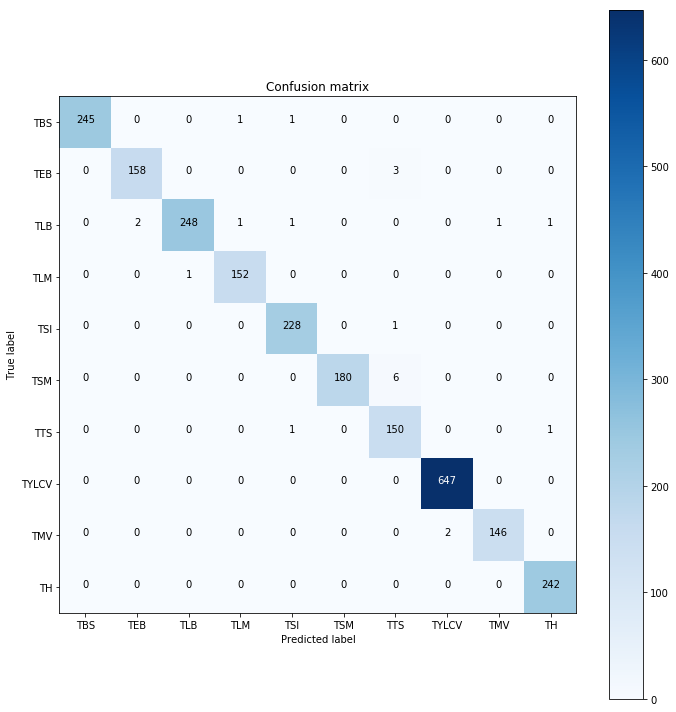

In [26]:
from matplotlib  import pyplot as plt
import itertools
from sklearn.metrics import  confusion_matrix
import numpy as np
test_data_dir='./newtest/'
test_generator = datagen.flow_from_directory(directory=test_data_dir,
                                             shuffle=False,
                                             target_size=(imagesize, imagesize), 
                                             batch_size=BATCH_SIZE    )
pred = inception_model.predict_generator(test_generator,verbose=1,steps=len(test_generator))
pred_lable = np.argmax(pred, axis=1)
cnf_matrix = confusion_matrix(test_generator.classes,pred_lable)

import scipy.io as sio 
sio.savemat('./saveddata.mat', {'groundth': test_generator.classes,'pred': pred_lable})

label = list(set(test_generator.classes))
classes = ['TBS',  'TEB',  'TLB', 'TLM',  'TSl', 'TSM',  'TTS',  'TYLCV','TMV', 'TH' ]
a = classes
# a = []
# for i in label:
#     a.append(classes[i])
    
plt.figure(figsize=(10,10))   
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks =  np.arange(len(a))
plt.xticks(tick_marks, a, )
plt.yticks(tick_marks, a)

thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if cnf_matrix[i,j] ==0:
        text1 = cnf_matrix[i,j]
        fmt = 'd'
#         text1 = 'N'
#         fmt = 's'
         
    else:
        text1 = cnf_matrix[i,j]
        fmt = 'd'
    plt.text(j, i, format(text1, fmt),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [27]:
test_generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

# Transfer '.h5' model to '.pb' model

In [10]:
import tensorflow as tf
import os

from tensorflow.python.framework import graph_util

from keras.models import load_model
from keras import backend as K


path_to_model = './model/Inception_0401.h5'
model = load_model(path_to_model)

K.set_learning_phase(0)

sess = K.get_session()
output_fld = './model/'
if not os.path.isdir(output_fld):
    os.mkdir(output_fld)
    
output_graph_name =  'Inception_0401.pb'
ouputname = model.output.name

constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), [ouputname[0:-2] ])
tf.train.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', os.path.join(output_fld, output_graph_name))


INFO:tensorflow:Froze 400 variables.
INFO:tensorflow:Converted 400 variables to const ops.
saved the constant graph (ready for inference) at:  ./model/Inception_0401.pb


# Check the scope name of  '.pb' model 

In [11]:
import tensorflow as tf

with tf.gfile.GFile('./model/Inception_0401.pb', "rb") as f:  
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Graph().as_default() as graph:  
    tf.import_graph_def(graph_def, name="")  
    for op in graph.get_operations(): 
        print(op.name, )

batch_normalization_1/keras_learning_phase/input
batch_normalization_1/keras_learning_phase
image_input_4
conv2d_1_2/kernel
conv2d_1_2/kernel/read
batch_normalization_5_2/beta
batch_normalization_5_2/beta/read
batch_normalization_5_2/moving_mean
batch_normalization_5_2/moving_mean/read
batch_normalization_5_2/moving_variance
batch_normalization_5_2/moving_variance/read
conv2d_2_2/kernel
conv2d_2_2/kernel/read
batch_normalization_6_2/beta
batch_normalization_6_2/beta/read
batch_normalization_6_2/moving_mean
batch_normalization_6_2/moving_mean/read
batch_normalization_6_2/moving_variance
batch_normalization_6_2/moving_variance/read
conv2d_3_2/kernel
conv2d_3_2/kernel/read
batch_normalization_7_2/beta
batch_normalization_7_2/beta/read
batch_normalization_7_2/moving_mean
batch_normalization_7_2/moving_mean/read
batch_normalization_7_2/moving_variance
batch_normalization_7_2/moving_variance/read
conv2d_4_2/kernel
conv2d_4_2/kernel/read
batch_normalization_8_2/beta
batch_normalization_8_2/be

# Activation Maximization 

In [1]:
%matplotlib inline
from vis.utils import utils
from vis.visualization import visualize_activation,visualize_cam
from vis.input_modifiers import Jitter
from keras import activations
from keras.models import load_model
from matplotlib import pyplot as plt
from keras import backend as K

K.clear_session()
model = load_model('./model/Inception_0401.h5',compile= False)
model.summary()
print('load done')

layer_idx = utils.find_layer_idx(model, 'pred')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_99 (Batc (None, 256)               1024      
_________________________________________________________________
activation_98 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
__________

/home/kai00004/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Iteration: 1, named_losses: [('ActivationMax Loss', -41.64021),
 ('L-6.0 Norm Loss', 0.063256465),
 ('TV(2.0) Loss', 6461.5254)], overall loss: 6419.9482421875
Iteration: 2, named_losses: [('ActivationMax Loss', -41.28277),
 ('L-6.0 Norm Loss', 0.06268285),
 ('TV(2.0) Loss', 3443.14)], overall loss: 3401.919921875
Iteration: 3, named_losses: [('ActivationMax Loss', -48.410267),
 ('L-6.0 Norm Loss', 0.062330544),
 ('TV(2.0) Loss', 1773.2803)], overall loss: 1724.932373046875
Iteration: 4, named_losses: [('ActivationMax Loss', -56.03258),
 ('L-6.0 Norm Loss', 0.06210658),
 ('TV(2.0) Loss', 838.7286)], overall loss: 782.7581176757812
Iteration: 5, named_losses: [('ActivationMax Loss', -65.15219),
 ('L-6.0 Norm Loss', 0.061968282),
 ('TV(2.0) Loss', 348.72433)], overall loss: 283.63409423828125
Iteration: 6, named_losses: [('ActivationMax Loss', -69.18666),
 ('L-6.0 Norm Loss', 0.061892398),
 ('TV(2.0) Loss', 138.3385)], overall loss: 69.21372985839844
Iteration: 7, named_losses: [('Activa

Iteration: 52, named_losses: [('ActivationMax Loss', -83.07228),
 ('L-6.0 Norm Loss', 0.06191805),
 ('TV(2.0) Loss', 36.478928)], overall loss: -46.53143310546875
Iteration: 53, named_losses: [('ActivationMax Loss', -101.17606),
 ('L-6.0 Norm Loss', 0.061917815),
 ('TV(2.0) Loss', 35.797993)], overall loss: -65.31614685058594
Iteration: 54, named_losses: [('ActivationMax Loss', -110.48166),
 ('L-6.0 Norm Loss', 0.06192368),
 ('TV(2.0) Loss', 37.392315)], overall loss: -73.02742004394531
Iteration: 55, named_losses: [('ActivationMax Loss', -98.811264),
 ('L-6.0 Norm Loss', 0.061927523),
 ('TV(2.0) Loss', 37.098442)], overall loss: -61.65089416503906
Iteration: 56, named_losses: [('ActivationMax Loss', -101.62405),
 ('L-6.0 Norm Loss', 0.061929345),
 ('TV(2.0) Loss', 36.265057)], overall loss: -65.29705810546875
Iteration: 57, named_losses: [('ActivationMax Loss', -105.145615),
 ('L-6.0 Norm Loss', 0.06193625),
 ('TV(2.0) Loss', 39.6834)], overall loss: -65.40028381347656
Iteration: 58, 

Iteration: 104, named_losses: [('ActivationMax Loss', -120.199905),
 ('L-6.0 Norm Loss', 0.062050875),
 ('TV(2.0) Loss', 36.901726)], overall loss: -83.23612976074219
Iteration: 105, named_losses: [('ActivationMax Loss', -115.27757),
 ('L-6.0 Norm Loss', 0.062058765),
 ('TV(2.0) Loss', 40.338882)], overall loss: -74.87663269042969
Iteration: 106, named_losses: [('ActivationMax Loss', -109.811676),
 ('L-6.0 Norm Loss', 0.062060967),
 ('TV(2.0) Loss', 39.32672)], overall loss: -70.42289733886719
Iteration: 107, named_losses: [('ActivationMax Loss', -111.10237),
 ('L-6.0 Norm Loss', 0.06206446),
 ('TV(2.0) Loss', 39.63482)], overall loss: -71.40548706054688
Iteration: 108, named_losses: [('ActivationMax Loss', -113.53388),
 ('L-6.0 Norm Loss', 0.062066525),
 ('TV(2.0) Loss', 38.337563)], overall loss: -75.1342544555664
Iteration: 109, named_losses: [('ActivationMax Loss', -90.69027),
 ('L-6.0 Norm Loss', 0.06207597),
 ('TV(2.0) Loss', 40.512695)], overall loss: -50.115501403808594
Iterati

Iteration: 156, named_losses: [('ActivationMax Loss', -81.477646),
 ('L-6.0 Norm Loss', 0.06220503),
 ('TV(2.0) Loss', 42.604218)], overall loss: -38.81122589111328
Iteration: 157, named_losses: [('ActivationMax Loss', -81.05165),
 ('L-6.0 Norm Loss', 0.062201403),
 ('TV(2.0) Loss', 39.54145)], overall loss: -41.447998046875
Iteration: 158, named_losses: [('ActivationMax Loss', -85.803604),
 ('L-6.0 Norm Loss', 0.062204316),
 ('TV(2.0) Loss', 41.58599)], overall loss: -44.15541076660156
Iteration: 159, named_losses: [('ActivationMax Loss', -73.27843),
 ('L-6.0 Norm Loss', 0.06220421),
 ('TV(2.0) Loss', 41.03328)], overall loss: -32.182945251464844
Iteration: 160, named_losses: [('ActivationMax Loss', -77.7038),
 ('L-6.0 Norm Loss', 0.062202275),
 ('TV(2.0) Loss', 38.810066)], overall loss: -38.83152770996094
Iteration: 161, named_losses: [('ActivationMax Loss', -87.07644),
 ('L-6.0 Norm Loss', 0.06220942),
 ('TV(2.0) Loss', 41.508556)], overall loss: -45.505672454833984
Iteration: 162,

Iteration: 9, named_losses: [('ActivationMax Loss', -21.691935),
 ('L-6.0 Norm Loss', 0.061819717),
 ('TV(2.0) Loss', 55.182983)], overall loss: 33.5528678894043
Iteration: 10, named_losses: [('ActivationMax Loss', -21.437607),
 ('L-6.0 Norm Loss', 0.061816912),
 ('TV(2.0) Loss', 56.849716)], overall loss: 35.47392654418945
Iteration: 11, named_losses: [('ActivationMax Loss', -21.902729),
 ('L-6.0 Norm Loss', 0.0618165),
 ('TV(2.0) Loss', 48.11156)], overall loss: 26.270648956298828
Iteration: 12, named_losses: [('ActivationMax Loss', -21.71498),
 ('L-6.0 Norm Loss', 0.06181315),
 ('TV(2.0) Loss', 42.808365)], overall loss: 21.15519905090332
Iteration: 13, named_losses: [('ActivationMax Loss', -23.336708),
 ('L-6.0 Norm Loss', 0.06181367),
 ('TV(2.0) Loss', 44.80057)], overall loss: 21.525676727294922
Iteration: 14, named_losses: [('ActivationMax Loss', -21.65082),
 ('L-6.0 Norm Loss', 0.061811592),
 ('TV(2.0) Loss', 38.723167)], overall loss: 17.134159088134766
Iteration: 15, named_lo

Iteration: 62, named_losses: [('ActivationMax Loss', -20.94881),
 ('L-6.0 Norm Loss', 0.061824277),
 ('TV(2.0) Loss', 21.864038)], overall loss: 0.9770526885986328
Iteration: 63, named_losses: [('ActivationMax Loss', -19.299803),
 ('L-6.0 Norm Loss', 0.06182437),
 ('TV(2.0) Loss', 18.805658)], overall loss: -0.43231964111328125
Iteration: 64, named_losses: [('ActivationMax Loss', -15.332896),
 ('L-6.0 Norm Loss', 0.061824553),
 ('TV(2.0) Loss', 17.529858)], overall loss: 2.258786201477051
Iteration: 65, named_losses: [('ActivationMax Loss', -17.58649),
 ('L-6.0 Norm Loss', 0.061825734),
 ('TV(2.0) Loss', 18.412733)], overall loss: 0.8880672454833984
Iteration: 66, named_losses: [('ActivationMax Loss', -17.416851),
 ('L-6.0 Norm Loss', 0.061825562),
 ('TV(2.0) Loss', 19.263372)], overall loss: 1.908346176147461
Iteration: 67, named_losses: [('ActivationMax Loss', -18.66477),
 ('L-6.0 Norm Loss', 0.061825342),
 ('TV(2.0) Loss', 19.23053)], overall loss: 0.6275844573974609
Iteration: 68, 

Iteration: 112, named_losses: [('ActivationMax Loss', -18.354462),
 ('L-6.0 Norm Loss', 0.061847426),
 ('TV(2.0) Loss', 19.670494)], overall loss: 1.3778800964355469
Iteration: 113, named_losses: [('ActivationMax Loss', -19.641336),
 ('L-6.0 Norm Loss', 0.06184787),
 ('TV(2.0) Loss', 19.130102)], overall loss: -0.4493865966796875
Iteration: 114, named_losses: [('ActivationMax Loss', -19.29463),
 ('L-6.0 Norm Loss', 0.061849825),
 ('TV(2.0) Loss', 20.223448)], overall loss: 0.9906673431396484
Iteration: 115, named_losses: [('ActivationMax Loss', -18.635254),
 ('L-6.0 Norm Loss', 0.06184878),
 ('TV(2.0) Loss', 17.067467)], overall loss: -1.5059375762939453
Iteration: 116, named_losses: [('ActivationMax Loss', -20.161835),
 ('L-6.0 Norm Loss', 0.061849337),
 ('TV(2.0) Loss', 19.875668)], overall loss: -0.2243175506591797
Iteration: 117, named_losses: [('ActivationMax Loss', -20.412462),
 ('L-6.0 Norm Loss', 0.061848845),
 ('TV(2.0) Loss', 18.437403)], overall loss: -1.9132099151611328
Ite

Iteration: 162, named_losses: [('ActivationMax Loss', -26.503529),
 ('L-6.0 Norm Loss', 0.061883003),
 ('TV(2.0) Loss', 19.39704)], overall loss: -7.044605255126953
Iteration: 163, named_losses: [('ActivationMax Loss', -23.90896),
 ('L-6.0 Norm Loss', 0.061883837),
 ('TV(2.0) Loss', 21.65182)], overall loss: -2.1952571868896484
Iteration: 164, named_losses: [('ActivationMax Loss', -26.640736),
 ('L-6.0 Norm Loss', 0.06188399),
 ('TV(2.0) Loss', 20.779879)], overall loss: -5.798973083496094
Iteration: 165, named_losses: [('ActivationMax Loss', -25.776005),
 ('L-6.0 Norm Loss', 0.06188629),
 ('TV(2.0) Loss', 21.416012)], overall loss: -4.298107147216797
Iteration: 166, named_losses: [('ActivationMax Loss', -20.829336),
 ('L-6.0 Norm Loss', 0.061885774),
 ('TV(2.0) Loss', 18.897503)], overall loss: -1.8699474334716797
Iteration: 167, named_losses: [('ActivationMax Loss', -21.32115),
 ('L-6.0 Norm Loss', 0.061886646),
 ('TV(2.0) Loss', 19.825031)], overall loss: -1.4342327117919922
Iterati

Iteration: 14, named_losses: [('ActivationMax Loss', -73.82537),
 ('L-6.0 Norm Loss', 0.061832827),
 ('TV(2.0) Loss', 42.6647)], overall loss: -31.098834991455078
Iteration: 15, named_losses: [('ActivationMax Loss', -72.370995),
 ('L-6.0 Norm Loss', 0.061831553),
 ('TV(2.0) Loss', 40.675415)], overall loss: -31.633750915527344
Iteration: 16, named_losses: [('ActivationMax Loss', -69.14764),
 ('L-6.0 Norm Loss', 0.06183698),
 ('TV(2.0) Loss', 44.97087)], overall loss: -24.11492919921875
Iteration: 17, named_losses: [('ActivationMax Loss', -70.6749),
 ('L-6.0 Norm Loss', 0.061833598),
 ('TV(2.0) Loss', 38.142956)], overall loss: -32.4701042175293
Iteration: 18, named_losses: [('ActivationMax Loss', -58.89051),
 ('L-6.0 Norm Loss', 0.061837226),
 ('TV(2.0) Loss', 36.897186)], overall loss: -21.931488037109375
Iteration: 19, named_losses: [('ActivationMax Loss', -72.67978),
 ('L-6.0 Norm Loss', 0.061835885),
 ('TV(2.0) Loss', 37.87428)], overall loss: -34.7436637878418
Iteration: 20, named

Iteration: 67, named_losses: [('ActivationMax Loss', -79.219795),
 ('L-6.0 Norm Loss', 0.061903577),
 ('TV(2.0) Loss', 31.507307)], overall loss: -47.65058135986328
Iteration: 68, named_losses: [('ActivationMax Loss', -82.63323),
 ('L-6.0 Norm Loss', 0.061908986),
 ('TV(2.0) Loss', 34.962345)], overall loss: -47.60897445678711
Iteration: 69, named_losses: [('ActivationMax Loss', -68.30571),
 ('L-6.0 Norm Loss', 0.06190979),
 ('TV(2.0) Loss', 34.563606)], overall loss: -33.68019104003906
Iteration: 70, named_losses: [('ActivationMax Loss', -85.4988),
 ('L-6.0 Norm Loss', 0.061912473),
 ('TV(2.0) Loss', 32.805435)], overall loss: -52.63145446777344
Iteration: 71, named_losses: [('ActivationMax Loss', -80.432304),
 ('L-6.0 Norm Loss', 0.061912272),
 ('TV(2.0) Loss', 32.587914)], overall loss: -47.78247833251953
Iteration: 72, named_losses: [('ActivationMax Loss', -79.6095),
 ('L-6.0 Norm Loss', 0.061919395),
 ('TV(2.0) Loss', 33.880344)], overall loss: -45.667232513427734
Iteration: 73, n

Iteration: 119, named_losses: [('ActivationMax Loss', -55.61685),
 ('L-6.0 Norm Loss', 0.06197835),
 ('TV(2.0) Loss', 39.953682)], overall loss: -15.601192474365234
Iteration: 120, named_losses: [('ActivationMax Loss', -66.42782),
 ('L-6.0 Norm Loss', 0.0619762),
 ('TV(2.0) Loss', 38.743034)], overall loss: -27.62281036376953
Iteration: 121, named_losses: [('ActivationMax Loss', -69.5266),
 ('L-6.0 Norm Loss', 0.06198089),
 ('TV(2.0) Loss', 40.442825)], overall loss: -29.02179718017578
Iteration: 122, named_losses: [('ActivationMax Loss', -73.11726),
 ('L-6.0 Norm Loss', 0.061978485),
 ('TV(2.0) Loss', 36.326416)], overall loss: -36.72886657714844
Iteration: 123, named_losses: [('ActivationMax Loss', -78.81957),
 ('L-6.0 Norm Loss', 0.061981067),
 ('TV(2.0) Loss', 34.49714)], overall loss: -44.26045227050781
Iteration: 124, named_losses: [('ActivationMax Loss', -81.09275),
 ('L-6.0 Norm Loss', 0.061980937),
 ('TV(2.0) Loss', 35.812267)], overall loss: -45.218502044677734
Iteration: 125

Iteration: 171, named_losses: [('ActivationMax Loss', -83.41101),
 ('L-6.0 Norm Loss', 0.062123403),
 ('TV(2.0) Loss', 37.610733)], overall loss: -45.73815155029297
Iteration: 172, named_losses: [('ActivationMax Loss', -89.44559),
 ('L-6.0 Norm Loss', 0.06212979),
 ('TV(2.0) Loss', 39.75936)], overall loss: -49.62409973144531
Iteration: 173, named_losses: [('ActivationMax Loss', -67.59119),
 ('L-6.0 Norm Loss', 0.062128976),
 ('TV(2.0) Loss', 38.446323)], overall loss: -29.08273696899414
Iteration: 174, named_losses: [('ActivationMax Loss', -69.887115),
 ('L-6.0 Norm Loss', 0.062133018),
 ('TV(2.0) Loss', 40.775963)], overall loss: -29.04901885986328
Iteration: 175, named_losses: [('ActivationMax Loss', -61.181774),
 ('L-6.0 Norm Loss', 0.062131092),
 ('TV(2.0) Loss', 39.760075)], overall loss: -21.359569549560547
Iteration: 176, named_losses: [('ActivationMax Loss', -66.511665),
 ('L-6.0 Norm Loss', 0.062129136),
 ('TV(2.0) Loss', 43.633625)], overall loss: -22.815914154052734
Iterati

Iteration: 25, named_losses: [('ActivationMax Loss', -38.73621),
 ('L-6.0 Norm Loss', 0.061824586),
 ('TV(2.0) Loss', 30.569147)], overall loss: -8.10523796081543
Iteration: 26, named_losses: [('ActivationMax Loss', -37.295425),
 ('L-6.0 Norm Loss', 0.06182474),
 ('TV(2.0) Loss', 28.21723)], overall loss: -9.01637077331543
Iteration: 27, named_losses: [('ActivationMax Loss', -36.582233),
 ('L-6.0 Norm Loss', 0.06182603),
 ('TV(2.0) Loss', 27.653877)], overall loss: -8.866531372070312
Iteration: 28, named_losses: [('ActivationMax Loss', -38.72241),
 ('L-6.0 Norm Loss', 0.061826617),
 ('TV(2.0) Loss', 28.545937)], overall loss: -10.114646911621094
Iteration: 29, named_losses: [('ActivationMax Loss', -36.060596),
 ('L-6.0 Norm Loss', 0.061827388),
 ('TV(2.0) Loss', 28.831995)], overall loss: -7.166772842407227
Iteration: 30, named_losses: [('ActivationMax Loss', -37.91865),
 ('L-6.0 Norm Loss', 0.061828554),
 ('TV(2.0) Loss', 28.64776)], overall loss: -9.209062576293945
Iteration: 31, nam

Iteration: 77, named_losses: [('ActivationMax Loss', -41.962383),
 ('L-6.0 Norm Loss', 0.061887108),
 ('TV(2.0) Loss', 23.808292)], overall loss: -18.092205047607422
Iteration: 78, named_losses: [('ActivationMax Loss', -45.167347),
 ('L-6.0 Norm Loss', 0.061890543),
 ('TV(2.0) Loss', 25.62883)], overall loss: -19.476627349853516
Iteration: 79, named_losses: [('ActivationMax Loss', -48.74316),
 ('L-6.0 Norm Loss', 0.061892338),
 ('TV(2.0) Loss', 24.285044)], overall loss: -24.396223068237305
Iteration: 80, named_losses: [('ActivationMax Loss', -47.500755),
 ('L-6.0 Norm Loss', 0.061895043),
 ('TV(2.0) Loss', 25.312508)], overall loss: -22.126354217529297
Iteration: 81, named_losses: [('ActivationMax Loss', -48.479473),
 ('L-6.0 Norm Loss', 0.061896157),
 ('TV(2.0) Loss', 23.403345)], overall loss: -25.014230728149414
Iteration: 82, named_losses: [('ActivationMax Loss', -49.838985),
 ('L-6.0 Norm Loss', 0.061897684),
 ('TV(2.0) Loss', 26.583498)], overall loss: -23.19359016418457
Iterati

Iteration: 129, named_losses: [('ActivationMax Loss', -37.888775),
 ('L-6.0 Norm Loss', 0.061971035),
 ('TV(2.0) Loss', 22.438074)], overall loss: -15.388731002807617
Iteration: 130, named_losses: [('ActivationMax Loss', -42.704617),
 ('L-6.0 Norm Loss', 0.06197112),
 ('TV(2.0) Loss', 21.261763)], overall loss: -21.380884170532227
Iteration: 131, named_losses: [('ActivationMax Loss', -44.096085),
 ('L-6.0 Norm Loss', 0.061971694),
 ('TV(2.0) Loss', 23.647528)], overall loss: -20.38658332824707
Iteration: 132, named_losses: [('ActivationMax Loss', -47.518246),
 ('L-6.0 Norm Loss', 0.06197331),
 ('TV(2.0) Loss', 19.82419)], overall loss: -27.632081985473633
Iteration: 133, named_losses: [('ActivationMax Loss', -43.983627),
 ('L-6.0 Norm Loss', 0.06197717),
 ('TV(2.0) Loss', 25.98938)], overall loss: -17.932270050048828
Iteration: 134, named_losses: [('ActivationMax Loss', -43.960438),
 ('L-6.0 Norm Loss', 0.06197792),
 ('TV(2.0) Loss', 22.204607)], overall loss: -21.6938533782959
Iterati

Iteration: 180, named_losses: [('ActivationMax Loss', -35.703323),
 ('L-6.0 Norm Loss', 0.062028043),
 ('TV(2.0) Loss', 25.247559)], overall loss: -10.39373779296875
Iteration: 181, named_losses: [('ActivationMax Loss', -38.665356),
 ('L-6.0 Norm Loss', 0.06203091),
 ('TV(2.0) Loss', 26.486868)], overall loss: -12.116456985473633
Iteration: 182, named_losses: [('ActivationMax Loss', -40.130238),
 ('L-6.0 Norm Loss', 0.062030092),
 ('TV(2.0) Loss', 24.115677)], overall loss: -15.952529907226562
Iteration: 183, named_losses: [('ActivationMax Loss', -42.82808),
 ('L-6.0 Norm Loss', 0.06203351),
 ('TV(2.0) Loss', 27.522032)], overall loss: -15.244012832641602
Iteration: 184, named_losses: [('ActivationMax Loss', -40.316086),
 ('L-6.0 Norm Loss', 0.06203287),
 ('TV(2.0) Loss', 27.203566)], overall loss: -13.050485610961914
Iteration: 185, named_losses: [('ActivationMax Loss', -40.59579),
 ('L-6.0 Norm Loss', 0.06203281),
 ('TV(2.0) Loss', 24.872467)], overall loss: -15.66128921508789
Iterat

Iteration: 33, named_losses: [('ActivationMax Loss', -54.240948),
 ('L-6.0 Norm Loss', 0.06183162),
 ('TV(2.0) Loss', 26.575712)], overall loss: -27.603403091430664
Iteration: 34, named_losses: [('ActivationMax Loss', -56.44878),
 ('L-6.0 Norm Loss', 0.06183217),
 ('TV(2.0) Loss', 27.25484)], overall loss: -29.13210678100586
Iteration: 35, named_losses: [('ActivationMax Loss', -50.170864),
 ('L-6.0 Norm Loss', 0.061834846),
 ('TV(2.0) Loss', 27.848017)], overall loss: -22.261011123657227
Iteration: 36, named_losses: [('ActivationMax Loss', -53.573406),
 ('L-6.0 Norm Loss', 0.061833844),
 ('TV(2.0) Loss', 24.430729)], overall loss: -29.08084487915039
Iteration: 37, named_losses: [('ActivationMax Loss', -54.515625),
 ('L-6.0 Norm Loss', 0.061835743),
 ('TV(2.0) Loss', 26.517849)], overall loss: -27.93593978881836
Iteration: 38, named_losses: [('ActivationMax Loss', -52.59649),
 ('L-6.0 Norm Loss', 0.06183598),
 ('TV(2.0) Loss', 26.57685)], overall loss: -25.957801818847656
Iteration: 39,

Iteration: 83, named_losses: [('ActivationMax Loss', -60.595882),
 ('L-6.0 Norm Loss', 0.06190926),
 ('TV(2.0) Loss', 26.402601)], overall loss: -34.131370544433594
Iteration: 84, named_losses: [('ActivationMax Loss', -58.891598),
 ('L-6.0 Norm Loss', 0.06191085),
 ('TV(2.0) Loss', 26.618326)], overall loss: -32.21135711669922
Iteration: 85, named_losses: [('ActivationMax Loss', -58.82214),
 ('L-6.0 Norm Loss', 0.0619135),
 ('TV(2.0) Loss', 29.079405)], overall loss: -29.680822372436523
Iteration: 86, named_losses: [('ActivationMax Loss', -58.506557),
 ('L-6.0 Norm Loss', 0.061915442),
 ('TV(2.0) Loss', 27.619991)], overall loss: -30.824649810791016
Iteration: 87, named_losses: [('ActivationMax Loss', -54.650036),
 ('L-6.0 Norm Loss', 0.06191559),
 ('TV(2.0) Loss', 25.532831)], overall loss: -29.055288314819336
Iteration: 88, named_losses: [('ActivationMax Loss', -58.469463),
 ('L-6.0 Norm Loss', 0.061918423),
 ('TV(2.0) Loss', 26.285723)], overall loss: -32.12181854248047
Iteration: 8

Iteration: 136, named_losses: [('ActivationMax Loss', -43.734135),
 ('L-6.0 Norm Loss', 0.06196392),
 ('TV(2.0) Loss', 24.211273)], overall loss: -19.460899353027344
Iteration: 137, named_losses: [('ActivationMax Loss', -41.33115),
 ('L-6.0 Norm Loss', 0.061965395),
 ('TV(2.0) Loss', 25.515533)], overall loss: -15.753650665283203
Iteration: 138, named_losses: [('ActivationMax Loss', -43.666073),
 ('L-6.0 Norm Loss', 0.061967075),
 ('TV(2.0) Loss', 22.83535)], overall loss: -20.768756866455078
Iteration: 139, named_losses: [('ActivationMax Loss', -48.71509),
 ('L-6.0 Norm Loss', 0.061966926),
 ('TV(2.0) Loss', 23.979534)], overall loss: -24.67359161376953
Iteration: 140, named_losses: [('ActivationMax Loss', -49.110283),
 ('L-6.0 Norm Loss', 0.061967332),
 ('TV(2.0) Loss', 24.808105)], overall loss: -24.240211486816406
Iteration: 141, named_losses: [('ActivationMax Loss', -55.136024),
 ('L-6.0 Norm Loss', 0.06196862),
 ('TV(2.0) Loss', 26.963543)], overall loss: -28.110511779785156
Iter

Iteration: 188, named_losses: [('ActivationMax Loss', -49.94433),
 ('L-6.0 Norm Loss', 0.062054213),
 ('TV(2.0) Loss', 26.184963)], overall loss: -23.697311401367188
Iteration: 189, named_losses: [('ActivationMax Loss', -57.411488),
 ('L-6.0 Norm Loss', 0.06205373),
 ('TV(2.0) Loss', 23.63464)], overall loss: -33.71479415893555
Iteration: 190, named_losses: [('ActivationMax Loss', -59.785923),
 ('L-6.0 Norm Loss', 0.062053338),
 ('TV(2.0) Loss', 23.205847)], overall loss: -36.51802062988281
Iteration: 191, named_losses: [('ActivationMax Loss', -58.839725),
 ('L-6.0 Norm Loss', 0.06205724),
 ('TV(2.0) Loss', 26.80013)], overall loss: -31.977537155151367
Iteration: 192, named_losses: [('ActivationMax Loss', -61.423473),
 ('L-6.0 Norm Loss', 0.06205958),
 ('TV(2.0) Loss', 26.470337)], overall loss: -34.891075134277344
Iteration: 193, named_losses: [('ActivationMax Loss', -62.40389),
 ('L-6.0 Norm Loss', 0.0620612),
 ('TV(2.0) Loss', 29.49398)], overall loss: -32.84784698486328
Iteration: 

Iteration: 39, named_losses: [('ActivationMax Loss', -71.74675),
 ('L-6.0 Norm Loss', 0.061854016),
 ('TV(2.0) Loss', 28.808226)], overall loss: -42.876670837402344
Iteration: 40, named_losses: [('ActivationMax Loss', -70.35656),
 ('L-6.0 Norm Loss', 0.061854314),
 ('TV(2.0) Loss', 27.658571)], overall loss: -42.636138916015625
Iteration: 41, named_losses: [('ActivationMax Loss', -63.7079),
 ('L-6.0 Norm Loss', 0.06185917),
 ('TV(2.0) Loss', 31.400627)], overall loss: -32.24541473388672
Iteration: 42, named_losses: [('ActivationMax Loss', -72.87589),
 ('L-6.0 Norm Loss', 0.06185961),
 ('TV(2.0) Loss', 31.194954)], overall loss: -41.61907958984375
Iteration: 43, named_losses: [('ActivationMax Loss', -75.6768),
 ('L-6.0 Norm Loss', 0.061861806),
 ('TV(2.0) Loss', 30.710258)], overall loss: -44.904685974121094
Iteration: 44, named_losses: [('ActivationMax Loss', -75.367325),
 ('L-6.0 Norm Loss', 0.061862122),
 ('TV(2.0) Loss', 30.90585)], overall loss: -44.39961624145508
Iteration: 45, na

Iteration: 92, named_losses: [('ActivationMax Loss', -63.415894),
 ('L-6.0 Norm Loss', 0.061928175),
 ('TV(2.0) Loss', 24.754494)], overall loss: -38.59947204589844
Iteration: 93, named_losses: [('ActivationMax Loss', -60.595764),
 ('L-6.0 Norm Loss', 0.06192923),
 ('TV(2.0) Loss', 26.007109)], overall loss: -34.52672576904297
Iteration: 94, named_losses: [('ActivationMax Loss', -67.04333),
 ('L-6.0 Norm Loss', 0.0619326),
 ('TV(2.0) Loss', 27.254524)], overall loss: -39.72686767578125
Iteration: 95, named_losses: [('ActivationMax Loss', -62.820282),
 ('L-6.0 Norm Loss', 0.06193354),
 ('TV(2.0) Loss', 28.59595)], overall loss: -34.16239929199219
Iteration: 96, named_losses: [('ActivationMax Loss', -53.18764),
 ('L-6.0 Norm Loss', 0.061937425),
 ('TV(2.0) Loss', 28.015362)], overall loss: -25.110340118408203
Iteration: 97, named_losses: [('ActivationMax Loss', -54.163044),
 ('L-6.0 Norm Loss', 0.061936386),
 ('TV(2.0) Loss', 25.41316)], overall loss: -28.68794822692871
Iteration: 98, na

Iteration: 144, named_losses: [('ActivationMax Loss', -82.52828),
 ('L-6.0 Norm Loss', 0.06206521),
 ('TV(2.0) Loss', 35.09529)], overall loss: -47.37092590332031
Iteration: 145, named_losses: [('ActivationMax Loss', -79.91201),
 ('L-6.0 Norm Loss', 0.062062003),
 ('TV(2.0) Loss', 31.348314)], overall loss: -48.50163269042969
Iteration: 146, named_losses: [('ActivationMax Loss', -95.561356),
 ('L-6.0 Norm Loss', 0.062065504),
 ('TV(2.0) Loss', 33.198944)], overall loss: -62.30034637451172
Iteration: 147, named_losses: [('ActivationMax Loss', -80.13502),
 ('L-6.0 Norm Loss', 0.06207059),
 ('TV(2.0) Loss', 34.558517)], overall loss: -45.514427185058594
Iteration: 148, named_losses: [('ActivationMax Loss', -96.00296),
 ('L-6.0 Norm Loss', 0.06207476),
 ('TV(2.0) Loss', 36.088684)], overall loss: -59.852203369140625
Iteration: 149, named_losses: [('ActivationMax Loss', -107.98232),
 ('L-6.0 Norm Loss', 0.0620791),
 ('TV(2.0) Loss', 38.452225)], overall loss: -69.468017578125
Iteration: 150

Iteration: 197, named_losses: [('ActivationMax Loss', -70.54391),
 ('L-6.0 Norm Loss', 0.062149666),
 ('TV(2.0) Loss', 28.519379)], overall loss: -41.962379455566406
Iteration: 198, named_losses: [('ActivationMax Loss', -81.97085),
 ('L-6.0 Norm Loss', 0.062154595),
 ('TV(2.0) Loss', 28.519413)], overall loss: -53.389278411865234
Iteration: 199, named_losses: [('ActivationMax Loss', -72.28012),
 ('L-6.0 Norm Loss', 0.062156986),
 ('TV(2.0) Loss', 30.686111)], overall loss: -41.53185272216797
Iteration: 200, named_losses: [('ActivationMax Loss', -68.38302),
 ('L-6.0 Norm Loss', 0.06215866),
 ('TV(2.0) Loss', 29.148203)], overall loss: -39.17266082763672
Iteration: 1, named_losses: [('ActivationMax Loss', -9.5633745),
 ('L-6.0 Norm Loss', 0.06325569),
 ('TV(2.0) Loss', 6461.789)], overall loss: 6452.2890625
Iteration: 2, named_losses: [('ActivationMax Loss', -8.884466),
 ('L-6.0 Norm Loss', 0.06268272),
 ('TV(2.0) Loss', 3430.2888)], overall loss: 3421.467041015625
Iteration: 3, named_lo

Iteration: 49, named_losses: [('ActivationMax Loss', -27.38768),
 ('L-6.0 Norm Loss', 0.061817817),
 ('TV(2.0) Loss', 25.720959)], overall loss: -1.6049041748046875
Iteration: 50, named_losses: [('ActivationMax Loss', -16.037111),
 ('L-6.0 Norm Loss', 0.061819013),
 ('TV(2.0) Loss', 24.458946)], overall loss: 8.483654022216797
Iteration: 51, named_losses: [('ActivationMax Loss', -14.805358),
 ('L-6.0 Norm Loss', 0.06181961),
 ('TV(2.0) Loss', 25.40143)], overall loss: 10.657892227172852
Iteration: 52, named_losses: [('ActivationMax Loss', -13.022198),
 ('L-6.0 Norm Loss', 0.061819717),
 ('TV(2.0) Loss', 24.630306)], overall loss: 11.669928550720215
Iteration: 53, named_losses: [('ActivationMax Loss', -17.642965),
 ('L-6.0 Norm Loss', 0.061820213),
 ('TV(2.0) Loss', 27.967257)], overall loss: 10.386112213134766
Iteration: 54, named_losses: [('ActivationMax Loss', -15.95177),
 ('L-6.0 Norm Loss', 0.06182088),
 ('TV(2.0) Loss', 21.583418)], overall loss: 5.693469047546387
Iteration: 55, n

Iteration: 100, named_losses: [('ActivationMax Loss', -22.794092),
 ('L-6.0 Norm Loss', 0.06182864),
 ('TV(2.0) Loss', 24.002205)], overall loss: 1.2699413299560547
Iteration: 101, named_losses: [('ActivationMax Loss', -25.8907),
 ('L-6.0 Norm Loss', 0.06182786),
 ('TV(2.0) Loss', 23.568485)], overall loss: -2.260385513305664
Iteration: 102, named_losses: [('ActivationMax Loss', -28.596415),
 ('L-6.0 Norm Loss', 0.061829694),
 ('TV(2.0) Loss', 26.874674)], overall loss: -1.6599102020263672
Iteration: 103, named_losses: [('ActivationMax Loss', -26.61314),
 ('L-6.0 Norm Loss', 0.06182803),
 ('TV(2.0) Loss', 26.812153)], overall loss: 0.26084136962890625
Iteration: 104, named_losses: [('ActivationMax Loss', -28.097952),
 ('L-6.0 Norm Loss', 0.061829332),
 ('TV(2.0) Loss', 21.439617)], overall loss: -6.596506118774414
Iteration: 105, named_losses: [('ActivationMax Loss', -30.400562),
 ('L-6.0 Norm Loss', 0.06183033),
 ('TV(2.0) Loss', 24.792324)], overall loss: -5.546407699584961
Iteration

Iteration: 153, named_losses: [('ActivationMax Loss', -23.239012),
 ('L-6.0 Norm Loss', 0.061841827),
 ('TV(2.0) Loss', 24.903038)], overall loss: 1.7258682250976562
Iteration: 154, named_losses: [('ActivationMax Loss', -23.984432),
 ('L-6.0 Norm Loss', 0.061840124),
 ('TV(2.0) Loss', 20.47915)], overall loss: -3.443441390991211
Iteration: 155, named_losses: [('ActivationMax Loss', -21.978098),
 ('L-6.0 Norm Loss', 0.061841577),
 ('TV(2.0) Loss', 26.900906)], overall loss: 4.984649658203125
Iteration: 156, named_losses: [('ActivationMax Loss', -23.840712),
 ('L-6.0 Norm Loss', 0.06184197),
 ('TV(2.0) Loss', 20.760143)], overall loss: -3.018726348876953
Iteration: 157, named_losses: [('ActivationMax Loss', -24.740562),
 ('L-6.0 Norm Loss', 0.061842367),
 ('TV(2.0) Loss', 25.8476)], overall loss: 1.1688804626464844
Iteration: 158, named_losses: [('ActivationMax Loss', -22.637852),
 ('L-6.0 Norm Loss', 0.06184349),
 ('TV(2.0) Loss', 22.180065)], overall loss: -0.39594268798828125
Iteratio

Iteration: 5, named_losses: [('ActivationMax Loss', -23.89243),
 ('L-6.0 Norm Loss', 0.06196511),
 ('TV(2.0) Loss', 338.83014)], overall loss: 314.9996643066406
Iteration: 6, named_losses: [('ActivationMax Loss', -22.454935),
 ('L-6.0 Norm Loss', 0.061883003),
 ('TV(2.0) Loss', 120.59475)], overall loss: 98.20169830322266
Iteration: 7, named_losses: [('ActivationMax Loss', -27.55293),
 ('L-6.0 Norm Loss', 0.06185347),
 ('TV(2.0) Loss', 70.97776)], overall loss: 43.4866828918457
Iteration: 8, named_losses: [('ActivationMax Loss', -26.664358),
 ('L-6.0 Norm Loss', 0.061839234),
 ('TV(2.0) Loss', 66.06877)], overall loss: 39.46625518798828
Iteration: 9, named_losses: [('ActivationMax Loss', -28.87027),
 ('L-6.0 Norm Loss', 0.0618316),
 ('TV(2.0) Loss', 59.87086)], overall loss: 31.062423706054688
Iteration: 10, named_losses: [('ActivationMax Loss', -25.578354),
 ('L-6.0 Norm Loss', 0.061828673),
 ('TV(2.0) Loss', 65.41886)], overall loss: 39.90233612060547
Iteration: 11, named_losses: [('

Iteration: 58, named_losses: [('ActivationMax Loss', -36.855194),
 ('L-6.0 Norm Loss', 0.061819244),
 ('TV(2.0) Loss', 23.49354)], overall loss: -13.299833297729492
Iteration: 59, named_losses: [('ActivationMax Loss', -32.48714),
 ('L-6.0 Norm Loss', 0.06181961),
 ('TV(2.0) Loss', 25.076477)], overall loss: -7.348842620849609
Iteration: 60, named_losses: [('ActivationMax Loss', -31.206827),
 ('L-6.0 Norm Loss', 0.061820034),
 ('TV(2.0) Loss', 25.10886)], overall loss: -6.03614616394043
Iteration: 61, named_losses: [('ActivationMax Loss', -25.692467),
 ('L-6.0 Norm Loss', 0.061820727),
 ('TV(2.0) Loss', 27.153383)], overall loss: 1.5227375030517578
Iteration: 62, named_losses: [('ActivationMax Loss', -20.389042),
 ('L-6.0 Norm Loss', 0.061821062),
 ('TV(2.0) Loss', 26.64271)], overall loss: 6.315488815307617
Iteration: 63, named_losses: [('ActivationMax Loss', -26.906107),
 ('L-6.0 Norm Loss', 0.061821826),
 ('TV(2.0) Loss', 20.857042)], overall loss: -5.98724365234375
Iteration: 64, na

Iteration: 111, named_losses: [('ActivationMax Loss', -32.797783),
 ('L-6.0 Norm Loss', 0.061857227),
 ('TV(2.0) Loss', 22.336754)], overall loss: -10.399169921875
Iteration: 112, named_losses: [('ActivationMax Loss', -33.83742),
 ('L-6.0 Norm Loss', 0.061860453),
 ('TV(2.0) Loss', 31.269121)], overall loss: -2.506441116333008
Iteration: 113, named_losses: [('ActivationMax Loss', -35.450485),
 ('L-6.0 Norm Loss', 0.061859645),
 ('TV(2.0) Loss', 28.383516)], overall loss: -7.005109786987305
Iteration: 114, named_losses: [('ActivationMax Loss', -31.947565),
 ('L-6.0 Norm Loss', 0.061859887),
 ('TV(2.0) Loss', 24.373232)], overall loss: -7.512474060058594
Iteration: 115, named_losses: [('ActivationMax Loss', -37.30142),
 ('L-6.0 Norm Loss', 0.06186368),
 ('TV(2.0) Loss', 28.946447)], overall loss: -8.293107986450195
Iteration: 116, named_losses: [('ActivationMax Loss', -35.04248),
 ('L-6.0 Norm Loss', 0.06186231),
 ('TV(2.0) Loss', 30.307072)], overall loss: -4.673545837402344
Iteration: 

Iteration: 163, named_losses: [('ActivationMax Loss', -35.971394),
 ('L-6.0 Norm Loss', 0.061898265),
 ('TV(2.0) Loss', 27.710617)], overall loss: -8.19887924194336
Iteration: 164, named_losses: [('ActivationMax Loss', -23.42808),
 ('L-6.0 Norm Loss', 0.06189727),
 ('TV(2.0) Loss', 28.985043)], overall loss: 5.618860244750977
Iteration: 165, named_losses: [('ActivationMax Loss', -21.790203),
 ('L-6.0 Norm Loss', 0.061896384),
 ('TV(2.0) Loss', 23.116507)], overall loss: 1.3882007598876953
Iteration: 166, named_losses: [('ActivationMax Loss', -19.83883),
 ('L-6.0 Norm Loss', 0.061897974),
 ('TV(2.0) Loss', 25.653555)], overall loss: 5.876621246337891
Iteration: 167, named_losses: [('ActivationMax Loss', -21.214966),
 ('L-6.0 Norm Loss', 0.06189607),
 ('TV(2.0) Loss', 25.127296)], overall loss: 3.9742259979248047
Iteration: 168, named_losses: [('ActivationMax Loss', -25.006142),
 ('L-6.0 Norm Loss', 0.06189554),
 ('TV(2.0) Loss', 25.033434)], overall loss: 0.0891876220703125
Iteration: 1

Iteration: 13, named_losses: [('ActivationMax Loss', -39.32713),
 ('L-6.0 Norm Loss', 0.06182988),
 ('TV(2.0) Loss', 43.766354)], overall loss: 4.5010528564453125
Iteration: 14, named_losses: [('ActivationMax Loss', -36.3223),
 ('L-6.0 Norm Loss', 0.061830208),
 ('TV(2.0) Loss', 46.529377)], overall loss: 10.268905639648438
Iteration: 15, named_losses: [('ActivationMax Loss', -36.21764),
 ('L-6.0 Norm Loss', 0.06182778),
 ('TV(2.0) Loss', 43.25344)], overall loss: 7.097629547119141
Iteration: 16, named_losses: [('ActivationMax Loss', -38.95513),
 ('L-6.0 Norm Loss', 0.061828468),
 ('TV(2.0) Loss', 40.597084)], overall loss: 1.7037811279296875
Iteration: 17, named_losses: [('ActivationMax Loss', -36.562187),
 ('L-6.0 Norm Loss', 0.06183022),
 ('TV(2.0) Loss', 40.86753)], overall loss: 4.3671722412109375
Iteration: 18, named_losses: [('ActivationMax Loss', -41.314667),
 ('L-6.0 Norm Loss', 0.061830055),
 ('TV(2.0) Loss', 40.32851)], overall loss: -0.9243278503417969
Iteration: 19, named_

Iteration: 66, named_losses: [('ActivationMax Loss', -37.533703),
 ('L-6.0 Norm Loss', 0.061873112),
 ('TV(2.0) Loss', 28.05694)], overall loss: -9.414888381958008
Iteration: 67, named_losses: [('ActivationMax Loss', -42.309288),
 ('L-6.0 Norm Loss', 0.06187273),
 ('TV(2.0) Loss', 23.405222)], overall loss: -18.842191696166992
Iteration: 68, named_losses: [('ActivationMax Loss', -35.560986),
 ('L-6.0 Norm Loss', 0.06187465),
 ('TV(2.0) Loss', 24.019245)], overall loss: -11.479866027832031
Iteration: 69, named_losses: [('ActivationMax Loss', -41.112022),
 ('L-6.0 Norm Loss', 0.061875887),
 ('TV(2.0) Loss', 27.638496)], overall loss: -13.411651611328125
Iteration: 70, named_losses: [('ActivationMax Loss', -40.02807),
 ('L-6.0 Norm Loss', 0.061875686),
 ('TV(2.0) Loss', 26.295185)], overall loss: -13.671009063720703
Iteration: 71, named_losses: [('ActivationMax Loss', -31.174368),
 ('L-6.0 Norm Loss', 0.06187802),
 ('TV(2.0) Loss', 26.767853)], overall loss: -4.344636917114258
Iteration: 

Iteration: 117, named_losses: [('ActivationMax Loss', -33.18875),
 ('L-6.0 Norm Loss', 0.061927594),
 ('TV(2.0) Loss', 20.999388)], overall loss: -12.127435684204102
Iteration: 118, named_losses: [('ActivationMax Loss', -38.830997),
 ('L-6.0 Norm Loss', 0.061929986),
 ('TV(2.0) Loss', 27.359007)], overall loss: -11.410058975219727
Iteration: 119, named_losses: [('ActivationMax Loss', -43.108444),
 ('L-6.0 Norm Loss', 0.061930913),
 ('TV(2.0) Loss', 26.84626)], overall loss: -16.200252532958984
Iteration: 120, named_losses: [('ActivationMax Loss', -40.096268),
 ('L-6.0 Norm Loss', 0.06193038),
 ('TV(2.0) Loss', 23.118864)], overall loss: -16.91547203063965
Iteration: 121, named_losses: [('ActivationMax Loss', -44.524082),
 ('L-6.0 Norm Loss', 0.06193324),
 ('TV(2.0) Loss', 27.410812)], overall loss: -17.05133819580078
Iteration: 122, named_losses: [('ActivationMax Loss', -40.837406),
 ('L-6.0 Norm Loss', 0.061932698),
 ('TV(2.0) Loss', 25.766047)], overall loss: -15.009428024291992
Iter

Iteration: 167, named_losses: [('ActivationMax Loss', -45.13795),
 ('L-6.0 Norm Loss', 0.062001586),
 ('TV(2.0) Loss', 27.760365)], overall loss: -17.31558609008789
Iteration: 168, named_losses: [('ActivationMax Loss', -44.48774),
 ('L-6.0 Norm Loss', 0.061999746),
 ('TV(2.0) Loss', 23.730423)], overall loss: -20.695316314697266
Iteration: 169, named_losses: [('ActivationMax Loss', -48.714756),
 ('L-6.0 Norm Loss', 0.06200457),
 ('TV(2.0) Loss', 26.049265)], overall loss: -22.603487014770508
Iteration: 170, named_losses: [('ActivationMax Loss', -48.45979),
 ('L-6.0 Norm Loss', 0.062004574),
 ('TV(2.0) Loss', 28.085245)], overall loss: -20.31254005432129
Iteration: 171, named_losses: [('ActivationMax Loss', -51.41106),
 ('L-6.0 Norm Loss', 0.062008258),
 ('TV(2.0) Loss', 26.910799)], overall loss: -24.43825340270996
Iteration: 172, named_losses: [('ActivationMax Loss', -46.37361),
 ('L-6.0 Norm Loss', 0.062007844),
 ('TV(2.0) Loss', 26.991657)], overall loss: -19.3199462890625
Iteration

Iteration: 17, named_losses: [('ActivationMax Loss', -26.21757),
 ('L-6.0 Norm Loss', 0.061814792),
 ('TV(2.0) Loss', 40.744034)], overall loss: 14.588279724121094
Iteration: 18, named_losses: [('ActivationMax Loss', -28.980421),
 ('L-6.0 Norm Loss', 0.061814994),
 ('TV(2.0) Loss', 37.37369)], overall loss: 8.455085754394531
Iteration: 19, named_losses: [('ActivationMax Loss', -27.571754),
 ('L-6.0 Norm Loss', 0.061814405),
 ('TV(2.0) Loss', 38.43707)], overall loss: 10.927129745483398
Iteration: 20, named_losses: [('ActivationMax Loss', -30.128656),
 ('L-6.0 Norm Loss', 0.06181657),
 ('TV(2.0) Loss', 35.11307)], overall loss: 5.046232223510742
Iteration: 21, named_losses: [('ActivationMax Loss', -28.516153),
 ('L-6.0 Norm Loss', 0.061813876),
 ('TV(2.0) Loss', 32.48787)], overall loss: 4.033529281616211
Iteration: 22, named_losses: [('ActivationMax Loss', -26.568611),
 ('L-6.0 Norm Loss', 0.061818454),
 ('TV(2.0) Loss', 30.399067)], overall loss: 3.892274856567383
Iteration: 23, named

Iteration: 68, named_losses: [('ActivationMax Loss', -20.854162),
 ('L-6.0 Norm Loss', 0.061816897),
 ('TV(2.0) Loss', 24.870844)], overall loss: 4.078498840332031
Iteration: 69, named_losses: [('ActivationMax Loss', -24.322517),
 ('L-6.0 Norm Loss', 0.06181742),
 ('TV(2.0) Loss', 26.1044)], overall loss: 1.8437004089355469
Iteration: 70, named_losses: [('ActivationMax Loss', -22.617935),
 ('L-6.0 Norm Loss', 0.061814405),
 ('TV(2.0) Loss', 25.039658)], overall loss: 2.4835376739501953
Iteration: 71, named_losses: [('ActivationMax Loss', -28.61972),
 ('L-6.0 Norm Loss', 0.061816633),
 ('TV(2.0) Loss', 26.641987)], overall loss: -1.9159164428710938
Iteration: 72, named_losses: [('ActivationMax Loss', -26.269266),
 ('L-6.0 Norm Loss', 0.061814513),
 ('TV(2.0) Loss', 26.460419)], overall loss: 0.25296783447265625
Iteration: 73, named_losses: [('ActivationMax Loss', -30.14451),
 ('L-6.0 Norm Loss', 0.06181679),
 ('TV(2.0) Loss', 24.811577)], overall loss: -5.271116256713867
Iteration: 74, 

Iteration: 120, named_losses: [('ActivationMax Loss', -33.647503),
 ('L-6.0 Norm Loss', 0.061839417),
 ('TV(2.0) Loss', 25.679136)], overall loss: -7.906526565551758
Iteration: 121, named_losses: [('ActivationMax Loss', -28.929457),
 ('L-6.0 Norm Loss', 0.061840266),
 ('TV(2.0) Loss', 25.850544)], overall loss: -3.0170726776123047
Iteration: 122, named_losses: [('ActivationMax Loss', -19.888998),
 ('L-6.0 Norm Loss', 0.06184125),
 ('TV(2.0) Loss', 25.266346)], overall loss: 5.439189910888672
Iteration: 123, named_losses: [('ActivationMax Loss', -18.423496),
 ('L-6.0 Norm Loss', 0.061842993),
 ('TV(2.0) Loss', 26.846094)], overall loss: 8.484441757202148
Iteration: 124, named_losses: [('ActivationMax Loss', -16.860771),
 ('L-6.0 Norm Loss', 0.06184253),
 ('TV(2.0) Loss', 25.186226)], overall loss: 8.387296676635742
Iteration: 125, named_losses: [('ActivationMax Loss', -21.387054),
 ('L-6.0 Norm Loss', 0.0618425),
 ('TV(2.0) Loss', 26.954786)], overall loss: 5.629573822021484
Iteration: 

Iteration: 173, named_losses: [('ActivationMax Loss', -25.613768),
 ('L-6.0 Norm Loss', 0.06185023),
 ('TV(2.0) Loss', 25.652328)], overall loss: 0.10041046142578125
Iteration: 174, named_losses: [('ActivationMax Loss', -25.709072),
 ('L-6.0 Norm Loss', 0.061852966),
 ('TV(2.0) Loss', 27.51527)], overall loss: 1.868051528930664
Iteration: 175, named_losses: [('ActivationMax Loss', -19.90921),
 ('L-6.0 Norm Loss', 0.06185118),
 ('TV(2.0) Loss', 27.817991)], overall loss: 7.970632553100586
Iteration: 176, named_losses: [('ActivationMax Loss', -20.713573),
 ('L-6.0 Norm Loss', 0.06185057),
 ('TV(2.0) Loss', 26.812784)], overall loss: 6.161062240600586
Iteration: 177, named_losses: [('ActivationMax Loss', -26.027353),
 ('L-6.0 Norm Loss', 0.061850864),
 ('TV(2.0) Loss', 27.072529)], overall loss: 1.1070270538330078
Iteration: 178, named_losses: [('ActivationMax Loss', -28.524693),
 ('L-6.0 Norm Loss', 0.061849933),
 ('TV(2.0) Loss', 25.723488)], overall loss: -2.7393550872802734
Iteration:

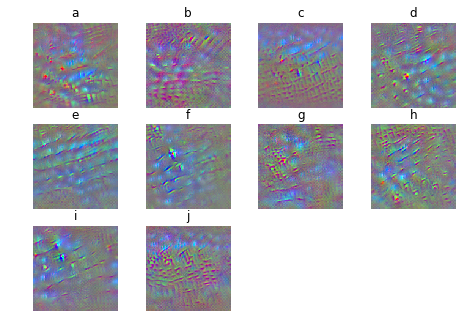

In [4]:
keptimage = []
for i in range(10):
    img = visualize_activation(model,layer_idx,filter_indices=i,
                               max_iter=200, verbose=1,
                               input_modifiers=[Jitter(16)]
                              )
    keptimage.append(img)

fig = plt.figure()
# plt.rcParams['figure.figsize'] = (50,50 )
title= [chr(i) for i in range(97,107)]
for i in range(10):
    plt.subplot(3,4,i+1,title=title[i])    
    plt.subplots_adjust(left=0, right=1,bottom=0,top=1)
    plt.imshow(keptimage[i])    
    plt.axis('off')
#     plt.tight_layout()
fig.savefig("feature_map_inception0401_0405.pdf",bbox_inches='tight', dpi=300)    

# Saliency map

In [ ]:
from vis.utils import utils
from keras import activations
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

model = load_model('./model/Inception_0401.h5',compile=0)

layer_idx = utils.find_layer_idx(model, 'pred')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

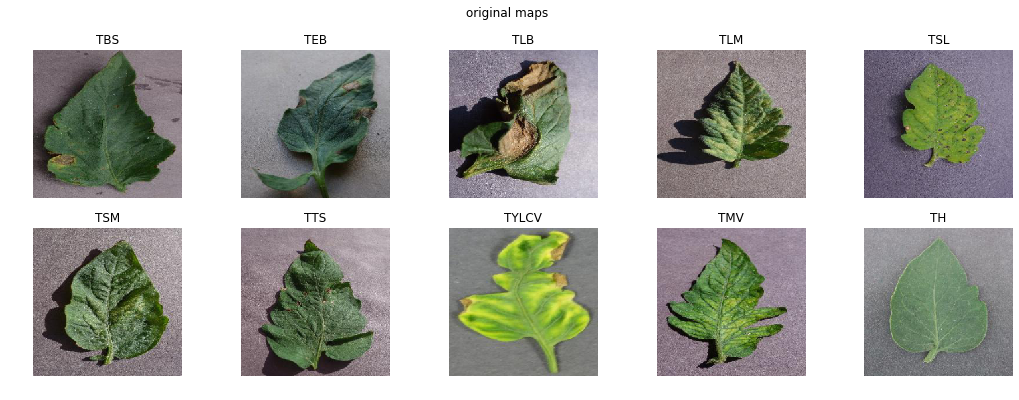

In [5]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

TBS = utils.load_img('./SaliencyMap/ColorBacterialSpot(1497).JPG', target_size=(224, 224))
TEB = utils.load_img('./SaliencyMap/ColorEarlyBlight(1000).JPG', target_size=(224, 224)) 
TLB = utils.load_img('./SaliencyMap/ColorLateBlight(1000).JPG', target_size=(224, 224)) 
TLM = utils.load_img('./SaliencyMap/ColorLeafMold(135).JPG', target_size=(224, 224)) 
TSL = utils.load_img('./SaliencyMap/ColorSeptoriaSpot(1000).JPG', target_size=(224, 224)) 
TSM = utils.load_img('./SaliencyMap/ColorSpiderMitesTeoSpottedSpiderMite(1000).JPG', target_size=(224, 224)) 
TTS = utils.load_img('./SaliencyMap/ColorTargetSpot(1000).JPG', target_size=(224, 224)) 
TYLCV = utils.load_img('./SaliencyMap/ColorTomatoYellowLeafCurlVirus(1200).JPG', target_size=(224, 224)) 
TMV = utils.load_img('./SaliencyMap/ColorTomatoMosaicVirus(121).JPG', target_size=(224, 224)) 
TH = utils.load_img('./SaliencyMap/ColorHealthy(1000).JPG', target_size=(224, 224)) 

originalimg = [TBS,TEB,TLB,TLM,TSL,TSM,TTS,TYLCV,TMV,TH]
title = ['TBS','TEB','TLB','TLM','TSL','TSM','TTS','TYLCV','TMV','TH']
f, ax = plt.subplots(2, 5)

plt.suptitle('original maps')
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(originalimg[i*5+j])
        ax[i,j].axis('off')
        ax[i,j].set_title(title[i*5+j])
f.savefig('saliency_originaliamge.pdf',dpi=300)

/home/kai00004/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


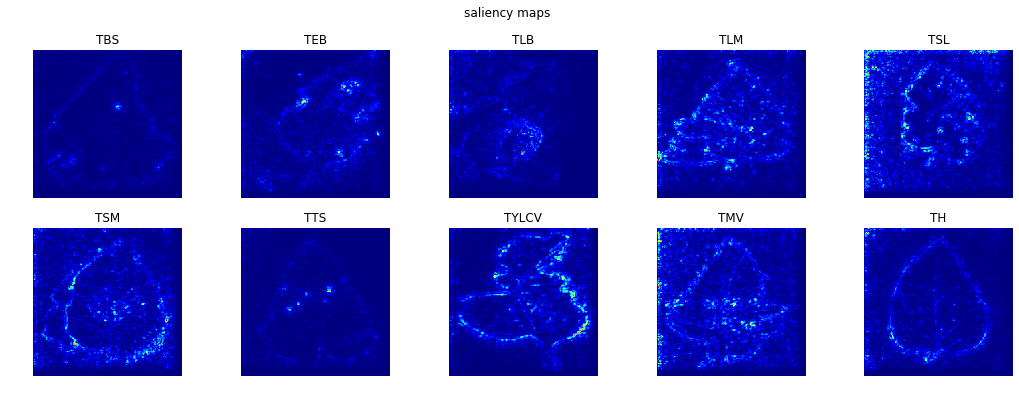

In [6]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

layer_idx = utils.find_layer_idx(model, 'pred')

f, ax = plt.subplots(2, 5)
plt.suptitle('saliency maps')
title = ['TBS','TEB','TLB','TLM','TSL','TSM','TTS','TYLCV','TMV','TH']
grads_all = []
for i in range(2):
    for j in range(5):
        grads = visualize_saliency(model, layer_idx, filter_indices=i*5+j, 
                                   seed_input=originalimg[i*5+j]/255,
                                  backprop_modifier='guided')
        grads_all.append(grads)  
        ax[i,j].imshow(grads, cmap='jet')
        ax[i,j].set_title(title[i*5+j])              
        ax[i,j].axis('off')
f.savefig('saliency_saliency.pdf',dpi=300)        

<Figure size 1296x432 with 0 Axes>

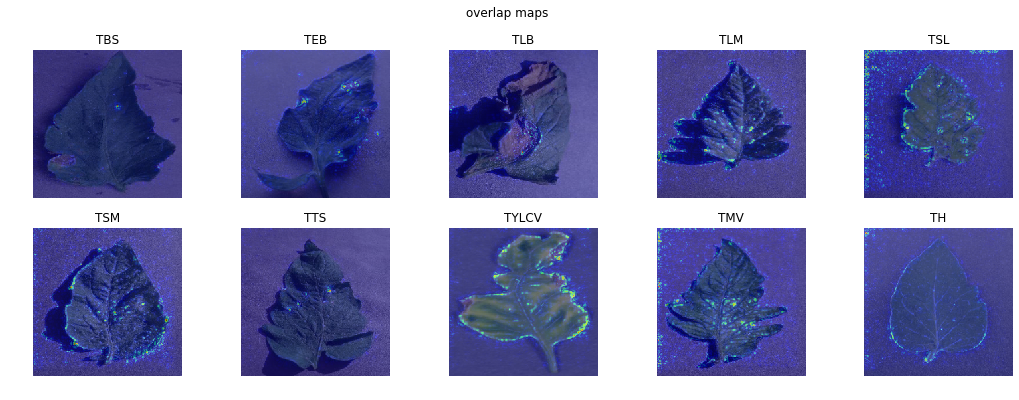

In [10]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import overlay

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.figure()
f, ax = plt.subplots(2, 5)
plt.suptitle('overlap maps')
overlay1 = []
title = ['TBS','TEB','TLB','TLM','TSL','TSM','TTS','TYLCV','TMV','TH']
for i in range(2):
    for j in range(5):
        grads = grads_all[i*5+j]
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ol = overlay(jet_heatmap, originalimg[i*5+j])
        overlay1.append(ol)
        ax[i,j].imshow(ol) 
        ax[i,j].axis('off')
        ax[i,j].set_title(title[i*5+j])
f.savefig('saliency_overlay.pdf',dpi=300)       